*Eduardus Tjitrahardja | @edutjie | 2022*

# Ristek Datathon 2022: Train

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from transformers import pipeline
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Helpers

In [2]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    data = history.history
    y1 = data['loss']
    y2 = data['val_loss']
    x = [i for i in range(len(y1))]
    ax[0].plot(x, y1, 'g-', label='Train Loss')
    ax[0].plot(x, y2, 'r--', label='Val Loss')
    ax[0].set_title('Training Loss vs Validation Loss')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    y1 = data['accuracy']
    y2 = data['val_accuracy']
    x = [i for i in range(len(y1))]
    ax[1].plot(x, y1, 'g-', label='Train Accuracy')
    ax[1].plot(x, y2, 'r--', label='Val Accuracy')
    ax[1].set_title('Training Accuracy vs Validation Accuracy')
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    plt.show()

## Load Data

In [3]:
combined_df = pd.read_csv('dataset/processed_combined.csv')

train_df = combined_df[combined_df['label'].notnull()]
test_df = combined_df[combined_df['label'].isnull() & combined_df['media'].notnull()]
unlabeled_df = combined_df[combined_df['label'].isnull() & combined_df['media'].isnull()]

train_df.shape, test_df.shape, unlabeled_df.shape, combined_df.shape

((1518, 8), (1011, 8), (9936, 8), (12465, 8))

In [17]:
train_df.head()

,created_at,id,user_id,user_name,url,text,media,label
0,2020-02-23 04:06:39+00:00,1231430140824973313,133931409,r0b1 sur1a (黄玉春),https://twitter.com/R0b1Sur1a/status/123143014...,akhir juga terobos banjir,ERbrKgFU4AAnADb.jpg,0.0
1,2020-01-05 01:46:46+00:00,1213637932411580417,253063316,Beradaptasi di Era Pandemi ☀️,https://twitter.com/MarikaRahman_/status/12136...,kemekes ri idi banten ibi banten ppni banten t...,ENe1HUVUEAANLFT.jpg,0.0
2,2020-01-18 06:22:09+00:00,1218418277946396673,64318803,rywyu,https://twitter.com/rywyu/status/1218418277946...,cikini rada banjir tdi pagi hingga gk tau apa ...,EOiw80RU0AcJ4CI.jpg,0.0
3,2020-02-22 23:38:00+00:00,1231362534717837313,17383917,ICALIZERS,https://twitter.com/icalizers/status/123136253...,sperma tt kala warga jakarta sedang prihatin b...,ERatrt9UYAAtLMI.jpg,0.0
4,2019-12-17 10:54:31+00:00,1206890412574568449,3102973556,AN,https://twitter.com/lokbin103/status/120689041...,kuis jakarta banjir parah hari tanya siapa yg ...,EL-8Z-vUcAIiIlV.jpg,0.0


## Combine Image and Textual Features

In [5]:
train_image_features = pd.read_csv('dataset/image_features/densenet_train_image_features.csv')
test_image_features = pd.read_csv('dataset/image_features/densenet_test_image_features.csv')

train_text_features = pd.read_csv('dataset/text_features/train_text_features.csv')
test_text_features = pd.read_csv('dataset/text_features/test_text_features.csv')
unlabeled_text_features = pd.read_csv('dataset/text_features/unlabeled_text_features.csv')

train_image_features.shape, test_image_features.shape, train_text_features.shape, test_text_features.shape, unlabeled_text_features.shape

((1518, 256), (1011, 256), (1518, 300), (1011, 300), (9936, 300))

In [6]:
# add prefix to column names
train_image_features.columns = ['image_' + col for col in train_image_features.columns]
test_image_features.columns = ['image_' + col for col in test_image_features.columns]
train_image_features.head()

,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,...,image_246,image_247,image_248,image_249,image_250,image_251,image_252,image_253,image_254,image_255
0,0.002412,0.255406,0.073089,0.020818,0.021223,0.001798,0.008892,0.010197,0.070118,0.018849,...,0.599071,0.667941,0.591719,0.772846,1.053931,0.563559,0.788448,0.933903,0.325151,0.782075
1,0.003262,0.209445,0.076465,0.020601,0.013247,0.001746,0.016001,0.010862,0.054241,0.016908,...,0.857704,0.663097,0.489337,0.604398,1.065173,1.656941,0.733056,0.339387,1.417239,2.256201
2,0.001464,0.083154,0.018514,0.024711,0.028696,0.002615,0.012801,0.007457,0.061622,0.019426,...,0.253258,0.468199,2.212710,0.125560,0.116755,0.070009,0.830658,0.214892,0.245031,0.456718
3,0.001842,0.070153,0.027252,0.012801,0.121898,0.001826,0.005749,0.007936,0.151572,0.014932,...,0.292904,0.090261,0.205571,0.167410,0.276909,0.267048,0.239819,0.328360,0.129048,0.646416
4,0.003214,0.142908,0.028323,0.022380,0.038958,0.001857,0.010106,0.006874,0.074566,0.024453,...,1.003480,0.561325,0.628901,0.472665,1.572514,1.373152,0.611522,0.283688,0.721310,1.036716


In [7]:
# add prefix to column names
train_text_features.columns = ['text_' + col for col in train_text_features.columns]
test_text_features.columns = ['text_' + col for col in test_text_features.columns]
unlabeled_text_features.columns = ['text_' + col for col in unlabeled_text_features.columns]
train_text_features.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,...,text_290,text_291,text_292,text_293,text_294,text_295,text_296,text_297,text_298,text_299
0,0.009883,-0.021286,0.025969,0.092511,0.028668,-0.028770,0.016315,-0.010510,0.008982,-0.090800,...,0.007333,0.013171,0.015966,-0.002016,0.032844,-0.006217,0.022417,-0.057426,0.017508,0.033850
1,0.034512,0.009235,0.018049,0.045457,0.006226,-0.075077,0.004485,-0.026857,-0.048104,-0.050542,...,-0.040443,-0.033196,-0.006029,0.014043,-0.015839,0.013577,0.005713,0.001407,-0.003548,0.020258
2,0.037173,-0.050290,0.011853,0.118136,-0.018496,-0.046303,0.029109,0.011791,-0.015547,-0.080154,...,-0.032494,-0.030817,-0.034458,0.015121,-0.031749,0.027591,-0.008889,-0.035597,-0.008871,0.061395
3,0.000976,-0.008979,0.025069,0.051203,0.021625,-0.046954,0.021365,0.008321,-0.029315,-0.015738,...,-0.010753,0.018024,-0.011522,-0.014646,0.006166,0.028416,0.047759,0.010205,-0.007385,0.051342
4,0.029130,0.045310,0.027381,0.040282,-0.047682,0.001377,0.017470,-0.008542,0.011416,-0.097448,...,-0.014846,-0.011152,-0.055743,0.017050,-0.014798,0.048946,0.032517,-0.016963,-0.012313,0.021128


### Combining

In [8]:
# combine image features and text features
X = pd.concat([train_image_features, train_text_features], axis=1)
X.head()

,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,...,text_290,text_291,text_292,text_293,text_294,text_295,text_296,text_297,text_298,text_299
0,0.002412,0.255406,0.073089,0.020818,0.021223,0.001798,0.008892,0.010197,0.070118,0.018849,...,0.007333,0.013171,0.015966,-0.002016,0.032844,-0.006217,0.022417,-0.057426,0.017508,0.033850
1,0.003262,0.209445,0.076465,0.020601,0.013247,0.001746,0.016001,0.010862,0.054241,0.016908,...,-0.040443,-0.033196,-0.006029,0.014043,-0.015839,0.013577,0.005713,0.001407,-0.003548,0.020258
2,0.001464,0.083154,0.018514,0.024711,0.028696,0.002615,0.012801,0.007457,0.061622,0.019426,...,-0.032494,-0.030817,-0.034458,0.015121,-0.031749,0.027591,-0.008889,-0.035597,-0.008871,0.061395
3,0.001842,0.070153,0.027252,0.012801,0.121898,0.001826,0.005749,0.007936,0.151572,0.014932,...,-0.010753,0.018024,-0.011522,-0.014646,0.006166,0.028416,0.047759,0.010205,-0.007385,0.051342
4,0.003214,0.142908,0.028323,0.022380,0.038958,0.001857,0.010106,0.006874,0.074566,0.024453,...,-0.014846,-0.011152,-0.055743,0.017050,-0.014798,0.048946,0.032517,-0.016963,-0.012313,0.021128


In [113]:
X.to_csv('dataset/densenet_features.csv', index=False)

In [4]:
X = pd.read_csv('dataset/densenet_features.csv')

In [5]:
y = train_df['label']
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: label, dtype: float64

In [6]:
y = y.astype(int)

## Feature Engineering

In [2]:
train_df_uncleaned = pd.read_csv('dataset/train.csv')
test_df_uncleaned = pd.read_csv('dataset/test.csv')
unlabeled_df_uncleaned = pd.read_csv('dataset/unlabeled.csv')

### Sentiment Feature

In [6]:
pretrained_name = "w11wo/indonesian-roberta-base-indonli"

roberta_indonli = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

In [30]:
train_df_uncleaned['text'][11]

'RIBUT SOAL BANJIR\n\nNih gua orang betawi, shohibul beit nya jakarta,\nGua bilangin ame elu, yang baru engeh ame jakarta, \nJakarta mah emang kampung aer, ade rawa sari, rawa bunga, rawa bokor, ame rawa rawa laen nye dah, \nYang nama nye rawa mah emang tempat aer, https://t.co/VFGMsBkKmk'

In [20]:
roberta_indonli(train_df_uncleaned['text'][11])

[{'label': 'entailment', 'score': 0.7383661866188049}]

In [21]:
roberta_indonli(train_df['text'][11])

[{'label': 'neutral', 'score': 0.6506001353263855}]

In [24]:
sentiment_df = pd.DataFrame(columns=['sentiment'])
sentiment_df['sentiment'] = train_df_uncleaned['text'].apply(lambda x: roberta_indonli(x)[0]['label'])
sentiment_df.head()

,sentiment
0,neutral
1,neutral
2,neutral
3,neutral
4,neutral


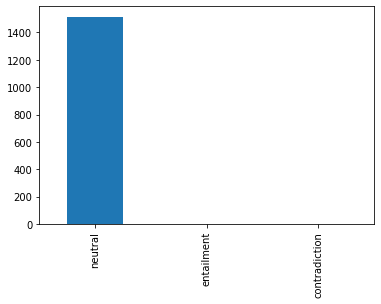

In [56]:
sentiment_df['sentiment'].value_counts().plot(kind='bar')
plt.show()

Most of them are neutral so it won't have any effect

In [26]:
# save sentiment_df
sentiment_df.to_csv('dataset/sentiment.csv', index=False)

In [38]:
sentiment_df = pd.read_csv('dataset/sentiment.csv')

In [27]:
# one hot encode sentiment
sentiment_df = pd.get_dummies(sentiment_df, columns=['sentiment'])
sentiment_df.head()

,sentiment_contradiction,sentiment_entailment,sentiment_neutral
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


### Emotion Feature

In [31]:
# https://huggingface.co/StevenLimcorn/indonesian-roberta-base-emotion-classifier?text=Hal-hal+baik+akan+datang.
pretrained_name = "StevenLimcorn/indonesian-roberta-base-emotion-classifier"

roberta_emotion = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

Downloading:   0%|          | 0.00/988 [00:00<?, ?B/s]

d:\miniconda3\envs\tf\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\edutjie\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/808k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [32]:
roberta_emotion(train_df_uncleaned['text'][11])

[{'label': 'happy', 'score': 0.851107120513916}]

In [33]:
emotion_df = pd.DataFrame(columns=['emotion'])
emotion_df['emotion'] = train_df_uncleaned['text'].apply(lambda x: roberta_emotion(x)[0]['label'])
emotion_df.head()

,emotion
0,happy
1,sadness
2,happy
3,sadness
4,happy


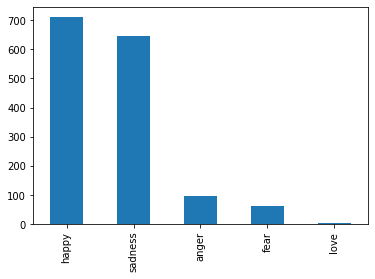

In [55]:
emotion_df['emotion'].value_counts().plot(kind='bar')
plt.show()

In [42]:
# save emotion_df
emotion_df.to_csv('dataset/emotion.csv', index=False)

In [7]:
emotion_df = pd.read_csv('dataset/emotion.csv')

In [44]:
# create a df where train_df[label] is the index and column is the emotion
emotion_df_pivot = emotion_df.pivot_table(index=train_df['label'], columns='emotion', aggfunc=len, fill_value=0)
emotion_df_pivot

emotion,anger,fear,happy,love,sadness
label,,,,,
0.0,87,51,646,2,406
1.0,8,11,65,1,241


In [8]:
emotion_df = pd.get_dummies(emotion_df, columns=['emotion'])
emotion_df.head()

,emotion_anger,emotion_fear,emotion_happy,emotion_love,emotion_sadness
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [9]:
X = pd.concat([X, emotion_df], axis=1)
X.head()

,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,...,text_295,text_296,text_297,text_298,text_299,emotion_anger,emotion_fear,emotion_happy,emotion_love,emotion_sadness
0,0.002412,0.255406,0.073089,0.020818,0.021223,0.001798,0.008892,0.010197,0.070118,0.018849,...,-0.006217,0.022417,-0.057426,0.017508,0.033850,0,0,1,0,0
1,0.003262,0.209445,0.076465,0.020601,0.013247,0.001746,0.016001,0.010862,0.054241,0.016908,...,0.013577,0.005713,0.001407,-0.003548,0.020258,0,0,0,0,1
2,0.001464,0.083154,0.018514,0.024711,0.028696,0.002615,0.012801,0.007457,0.061622,0.019426,...,0.027591,-0.008889,-0.035597,-0.008871,0.061395,0,0,1,0,0
3,0.001842,0.070153,0.027252,0.012801,0.121898,0.001826,0.005749,0.007936,0.151572,0.014932,...,0.028416,0.047759,0.010205,-0.007385,0.051342,0,0,0,0,1
4,0.003214,0.142908,0.028323,0.022380,0.038958,0.001857,0.010106,0.006874,0.074566,0.024453,...,0.048946,0.032517,-0.016963,-0.012313,0.021128,0,0,1,0,0


In [78]:
test_emotion_df = pd.DataFrame(columns=['emotion'])
test_emotion_df['emotion'] = test_df_uncleaned['text'].apply(lambda x: roberta_emotion(x)[0]['label'])
test_emotion_df = pd.get_dummies(test_emotion_df, columns=['emotion'])
test_emotion_df.head()

,emotion_anger,emotion_fear,emotion_happy,emotion_love,emotion_sadness
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [79]:
# save test_emotion_df
test_emotion_df.to_csv('dataset/test_emotion.csv', index=False)

In [10]:
test_emotion_df = pd.read_csv('dataset/test_emotion.csv')

In [ ]:
# unlabeled_emotion_df = pd.DataFrame(columns=['emotion'])
# unlabeled_emotion_df['emotion'] = unlabeled_df_uncleaned['text'].apply(lambda x: roberta_emotion(x)[0]['label'])
# unlabeled_emotion_df = pd.get_dummies(unlabeled_emotion_df, columns=['emotion'])
# unlabeled_emotion_df.head()

### Is_Banjir Feature

In [28]:
is_banjir_df = pd.DataFrame(columns=['is_banjir'])
is_banjir_df = train_df['text'].apply(lambda x: 'banjir' in x)
is_banjir_df.head()

0    True
1    True
2    True
3    True
4    True
Name: text, dtype: bool

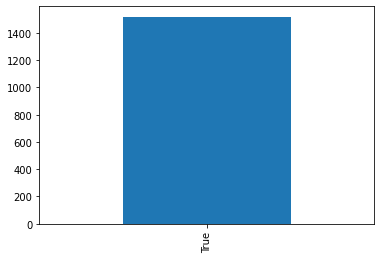

In [57]:
is_banjir_df.value_counts().plot(kind='bar')
plt.show()

All of them is True so it not going to have any effect

### Image Prediction Feature

In [3]:
image_train_path = "dataset/media/Image"

In [4]:
train_df_uncleaned["label"] = train_df_uncleaned["label"].astype(str)

In [5]:
batchsize = 16

train_gen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.05,
    horizontal_flip=True,
)
test_gen = ImageDataGenerator(rescale=1 / 255.0, horizontal_flip=True)

train_data_generator = train_gen.flow_from_dataframe(
    dataframe=train_df_uncleaned,
    directory=image_train_path,
    x_col="media",
    y_col="label",
    subset="training",
    batch_size=batchsize,
    target_size=(256, 256),
    class_mode="binary",
    shuffle=True,
    seed=7,
)

valid_data_generator = train_gen.flow_from_dataframe(
    dataframe=train_df_uncleaned,
    directory=image_train_path,
    x_col="media",
    y_col="label",
    subset="validation",
    batch_size=batchsize,
    target_size=(256, 256),
    class_mode="binary",
    shuffle=True,
    seed=7,
)

test_data_generator = test_gen.flow_from_dataframe(
    dataframe=test_df_uncleaned,
    directory=image_train_path,
    x_col="media",
    target_size=(256, 256),
    batch_size=1,
    class_mode=None,
    shuffle=False,
)


Found 1443 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 1011 validated image filenames.


In [6]:
base_xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
)
base_xception_model.trainable = True

xception_model = Sequential()
xception_model.add(base_xception_model)
xception_model.add(layers.GlobalAveragePooling2D())
xception_model.add(layers.Dense(1, activation="sigmoid"))
xception_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=1,
    verbose=0,
    mode="min",
    cooldown=0,
    min_lr=0,
)
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

xception_model_history = xception_model.fit(
    train_data_generator, validation_data=valid_data_generator, epochs=25, callbacks=[reduce_lr_callback, early_stop_callback]
)


Epoch 1/25
91/91 [==============================] - 48s 410ms/step - loss: 0.4247 - accuracy: 0.7990 - val_loss: 0.4732 - val_accuracy: 0.8533 - lr: 1.0000e-04
Epoch 2/25
91/91 [==============================] - 32s 350ms/step - loss: 0.3548 - accuracy: 0.8351 - val_loss: 0.3208 - val_accuracy: 0.8533 - lr: 1.0000e-04
Epoch 3/25
91/91 [==============================] - 32s 350ms/step - loss: 0.2791 - accuracy: 0.8822 - val_loss: 0.3268 - val_accuracy: 0.8533 - lr: 1.0000e-04
Epoch 4/25
91/91 [==============================] - 33s 355ms/step - loss: 0.2228 - accuracy: 0.9044 - val_loss: 0.3394 - val_accuracy: 0.8533 - lr: 1.0000e-05
Epoch 5/25
91/91 [==============================] - 34s 366ms/step - loss: 0.2177 - accuracy: 0.9092 - val_loss: 0.2726 - val_accuracy: 0.8667 - lr: 1.0000e-06
Epoch 6/25
91/91 [==============================] - 36s 391ms/step - loss: 0.2198 - accuracy: 0.9016 - val_loss: 0.3189 - val_accuracy: 0.8667 - lr: 1.0000e-06
Epoch 7/25
91/91 [======================

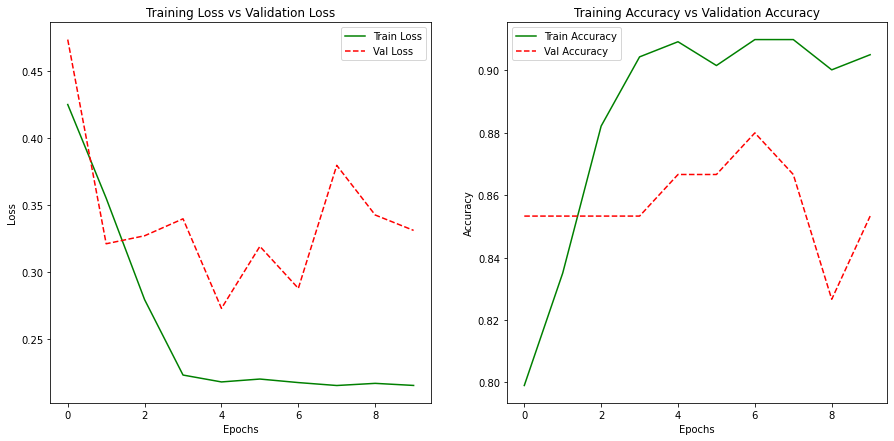

In [8]:
plot_history(xception_model_history)

In [15]:
print(classification_report(valid_data_generator.classes, xception_model.predict(valid_data_generator).round()))

5/5 [==============================] - 2s 302ms/step
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        60
           1       0.15      0.13      0.14        15

    accuracy                           0.68        75
   macro avg       0.47      0.47      0.47        75
weighted avg       0.66      0.68      0.67        75



## Modeling and Training

In [6]:
# split train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### SMOTE to solve imbalance data

In [25]:
smt = SMOTE()
print("Size of X_train before SMOTE: ", X_train.shape)
X_train, y_train = smt.fit_resample(X_train, y_train)
print("Size of X_train after SMOTE: ", X_train.shape)

Size of X_train before SMOTE:  (1214, 561)
Size of X_train after SMOTE:  (1896, 561)


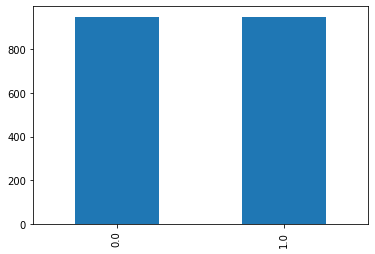

In [93]:
y_train.value_counts().plot(kind='bar')
plt.show()

### Deep Learning

In [26]:
dl_model = Sequential()
dl_model.add(layers.Dense(16, input_dim=X_train.shape[1], activation='relu'))
dl_model.add(layers.Dropout(0.2))
dl_model.add(layers.Dense(32, activation='relu'))
dl_model.add(layers.Dropout(0.2))
dl_model.add(layers.Dense(1, activation='sigmoid'))

# compile the model
dl_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
dl_model_history = dl_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=16)

Epoch 1/25
119/119 [==============================] - 1s 6ms/step - loss: 0.5915 - accuracy: 0.6857 - val_loss: 0.4587 - val_accuracy: 0.7928
Epoch 2/25
119/119 [==============================] - 1s 5ms/step - loss: 0.4473 - accuracy: 0.8012 - val_loss: 0.3231 - val_accuracy: 0.8388
Epoch 3/25
119/119 [==============================] - 1s 4ms/step - loss: 0.3998 - accuracy: 0.8254 - val_loss: 0.4204 - val_accuracy: 0.7895
Epoch 4/25
119/119 [==============================] - 1s 4ms/step - loss: 0.3699 - accuracy: 0.8581 - val_loss: 0.3664 - val_accuracy: 0.8224
Epoch 5/25
119/119 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8581 - val_loss: 0.3533 - val_accuracy: 0.8322
Epoch 6/25
119/119 [==============================] - 1s 5ms/step - loss: 0.3241 - accuracy: 0.8729 - val_loss: 0.3471 - val_accuracy: 0.8454
Epoch 7/25
119/119 [==============================] - 1s 4ms/step - loss: 0.3030 - accuracy: 0.8855 - val_loss: 0.5025 - val_accuracy: 0.7664
Epoch 

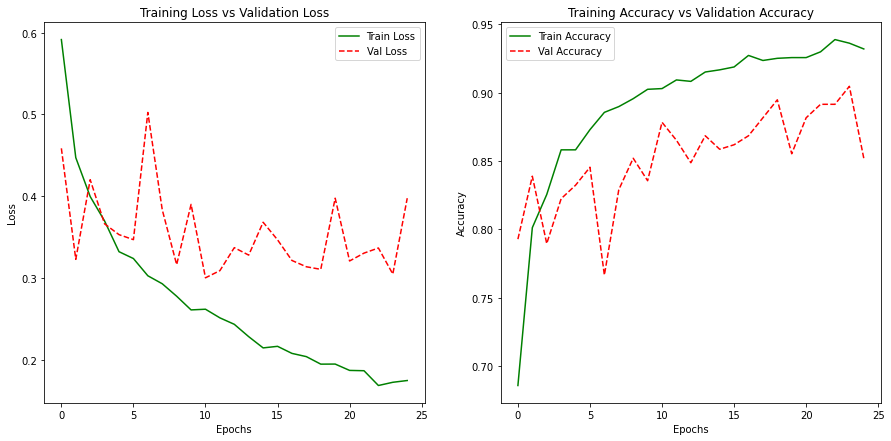

In [28]:
plot_history(dl_model_history)

In [15]:
print(classification_report(y_val, dl_model.predict(X_val).round()))

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       244
           1       0.75      0.63      0.68        60

    accuracy                           0.88       304
   macro avg       0.83      0.79      0.81       304
weighted avg       0.88      0.88      0.88       304



In [44]:
# SMOTE public submission: 0.80054 (HIGHEST)
print(classification_report(y_val, dl_model.predict(X_val).round()))

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       244
           1       0.59      0.82      0.69        60

    accuracy                           0.85       304
   macro avg       0.77      0.84      0.79       304
weighted avg       0.88      0.85      0.86       304



### CatBoost (worse)

In [7]:
clf_base_model = CatBoostClassifier(max_depth=9, random_state=42)
clf_base_model.fit(X_train, y_train, verbose=True)

Learning rate set to 0.011192
0:	learn: 0.6844600	total: 807ms	remaining: 13m 26s
1:	learn: 0.6763522	total: 1.41s	remaining: 11m 45s
2:	learn: 0.6679989	total: 2.13s	remaining: 11m 47s
3:	learn: 0.6602577	total: 2.73s	remaining: 11m 18s
4:	learn: 0.6522008	total: 3.26s	remaining: 10m 49s
5:	learn: 0.6458969	total: 3.86s	remaining: 10m 39s
6:	learn: 0.6380849	total: 4.4s	remaining: 10m 24s
7:	learn: 0.6308302	total: 5.07s	remaining: 10m 29s
8:	learn: 0.6248208	total: 5.7s	remaining: 10m 27s
9:	learn: 0.6185348	total: 6.35s	remaining: 10m 28s
10:	learn: 0.6113217	total: 7.02s	remaining: 10m 31s
11:	learn: 0.6048992	total: 7.63s	remaining: 10m 28s
12:	learn: 0.5978653	total: 8.26s	remaining: 10m 27s
13:	learn: 0.5915119	total: 8.83s	remaining: 10m 22s
14:	learn: 0.5855433	total: 9.44s	remaining: 10m 20s
15:	learn: 0.5781164	total: 10.1s	remaining: 10m 19s
16:	learn: 0.5715703	total: 10.7s	remaining: 10m 17s
17:	learn: 0.5653782	total: 11.3s	remaining: 10m 18s
18:	learn: 0.5592852	total: 

In [109]:
# VGG19
print(classification_report(y_val, clf_base_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       244
         1.0       0.68      0.43      0.53        60

    accuracy                           0.85       304
   macro avg       0.78      0.69      0.72       304
weighted avg       0.84      0.85      0.83       304



In [20]:
# with max_depth=9
print(classification_report(y_val, clf_base_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       244
         1.0       0.87      0.45      0.59        60

    accuracy                           0.88       304
   macro avg       0.88      0.72      0.76       304
weighted avg       0.88      0.88      0.86       304



In [14]:
# export model
clf_base_model.save_model('catboost_base_model')

In [75]:
# VGG19 after feature engineering
print(classification_report(y_val, clf_base_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       244
         1.0       0.79      0.45      0.57        60

    accuracy                           0.87       304
   macro avg       0.84      0.71      0.75       304
weighted avg       0.86      0.87      0.85       304



In [74]:
# export model after feature engineering
clf_base_model.save_model('catboost_after_fe_model')

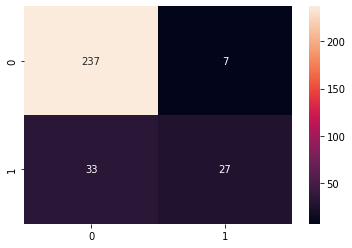

In [61]:
cm = confusion_matrix(y_val, clf_base_model.predict(X_val))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [117]:
# DENSENET after feature engineering
print(classification_report(y_val, clf_base_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       244
         1.0       0.81      0.50      0.62        60

    accuracy                           0.88       304
   macro avg       0.85      0.74      0.77       304
weighted avg       0.87      0.88      0.87       304



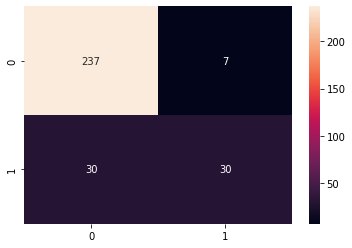

In [126]:
cm = confusion_matrix(y_val, clf_base_model.predict(X_val))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [116]:
# DENSENET export model after feature engineering
clf_base_model.save_model('densenet_catboost_after_fe')

In [2]:
# load model
clf_base_model = CatBoostClassifier()
clf_base_model.load_model('densenet_catboost_after_fe')

In [99]:
# DENSENET after feature engineering with SMOTE
print(classification_report(y_val, clf_base_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93       244
         1.0       0.68      0.75      0.71        60

    accuracy                           0.88       304
   macro avg       0.81      0.83      0.82       304
weighted avg       0.89      0.88      0.88       304



### LightGBM

In [31]:
params = {
    "application": "regression",
    "boosting": "gbdt",
    "metric": "rmse",
    "num_leaves": 70,
    "max_depth": 9,
    "learning_rate": 0.01,
    "bagging_fraction": 0.85,
    "feature_fraction": 0.8,
    "min_split_gain": 0.02,
    "min_child_samples": 150,
    "min_child_weight": 0.02,
    "lambda_l2": 0.0475,
    "verbosity": -1,
    "data_random_seed": 17,
}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_val, label=y_val)
valid_sets = [d_train, d_valid]

lgbm_model = lgb.train(
    params,
    train_set=d_train,
    num_boost_round=num_rounds,
    valid_sets=valid_sets,
    verbose_eval=verbose_eval,
    early_stopping_rounds=early_stop,
)

d:\miniconda3\envs\tf\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\miniconda3\envs\tf\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 0.36109	valid_1's rmse: 0.391534
[200]	training's rmse: 0.298995	valid_1's rmse: 0.353301
[300]	training's rmse: 0.262192	valid_1's rmse: 0.338773
[400]	training's rmse: 0.235998	valid_1's rmse: 0.330125
[500]	training's rmse: 0.216404	valid_1's rmse: 0.32533
[600]	training's rmse: 0.200333	valid_1's rmse: 0.322218
[700]	training's rmse: 0.186182	valid_1's rmse: 0.320103
[800]	training's rmse: 0.173636	valid_1's rmse: 0.318225
[900]	training's rmse: 0.162464	valid_1's rmse: 0.317584
[1000]	training's rmse: 0.15247	valid_1's rmse: 0.316088
[1100]	training's rmse: 0.14335	valid_1's rmse: 0.315225
[1200]	training's rmse: 0.134852	valid_1's rmse: 0.314919
[1300]	training's rmse: 0.127195	valid_1's rmse: 0.314501
[1400]	training's rmse: 0.120228	valid_1's rmse: 0.31406
[1500]	training's rmse: 0.113879	valid_1's rmse: 0.313753
[1600]	training's rmse: 0.107934	valid_1's rmse: 0.313135
[1700]	training's rmse: 

In [17]:
print(classification_report(y_val, lgbm_model.predict(X_val).round()))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       244
           1       0.80      0.65      0.72        60

    accuracy                           0.90       304
   macro avg       0.86      0.80      0.83       304
weighted avg       0.89      0.90      0.89       304



In [33]:
# SMOTE
print(classification_report(y_val, lgbm_model.predict(X_val).round()))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       244
           1       0.63      0.65      0.64        60

    accuracy                           0.86       304
   macro avg       0.77      0.78      0.77       304
weighted avg       0.86      0.86      0.86       304



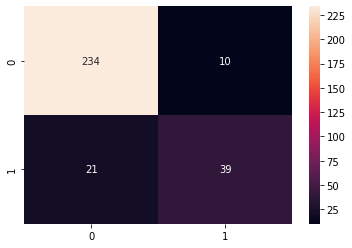

In [184]:
cm = confusion_matrix(y_val, lgbm_model.predict(X_val).round())
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

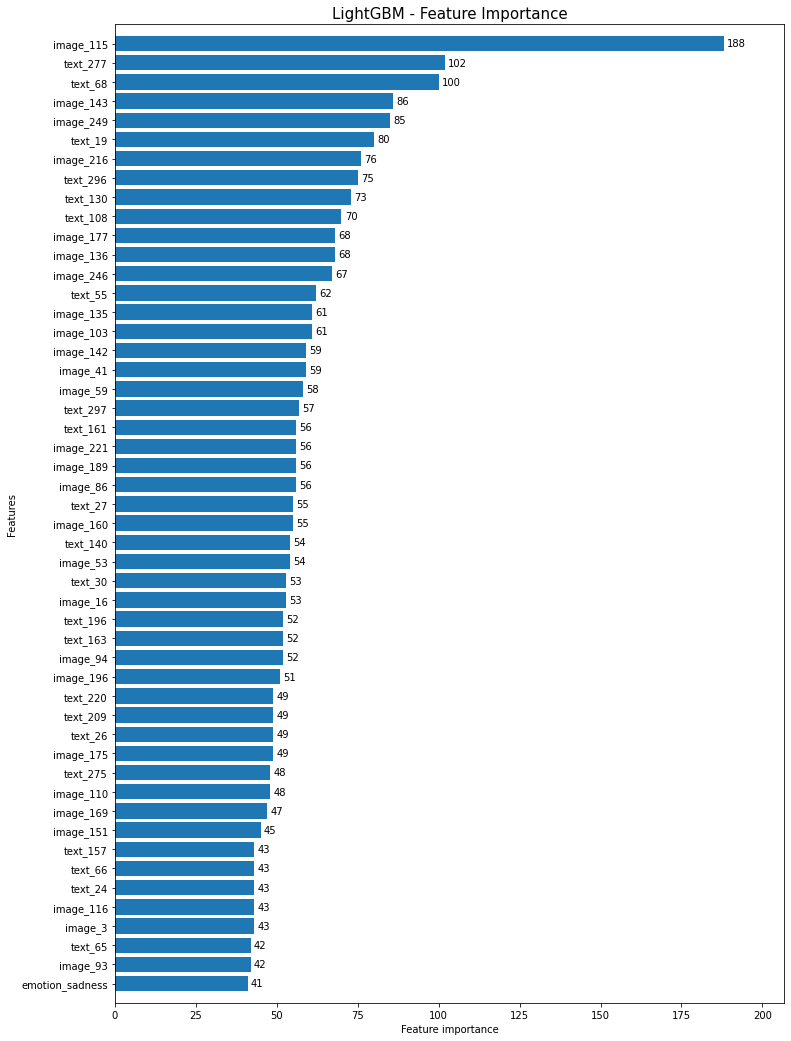

In [27]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgbm_model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [163]:
# save model
lgbm_model.save_model('lgbm_model')

In [2]:
lgbm_model = lgb.Booster(model_file='lgbm_model')

In [128]:
# svd
print(classification_report(y_val, lgbm_model.predict(X_val).round()))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       244
         1.0       0.75      0.55      0.63        60

    accuracy                           0.88       304
   macro avg       0.82      0.75      0.78       304
weighted avg       0.87      0.88      0.87       304



In [136]:
lgbm_model.predict(X_val).round()

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -0.,
        1.,  0.,  0.,  1., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
        0., -0., -0.,  1.,  0.,  0., -0.,  0.,  0.,  1., -0., -0.,  0.,
        1.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  1., -0.,  1.,  0.,  0.,  0.,  0.,  0.,
       -0.,  1.,  0.,  0., -0.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -0.,  0., -0., -0.,
        0., -0., -0.,  0.,  0.,  0.,  1., -0.,  1.,  0., -0.,  0.,  1.,
        0.,  1., -0.,  0.,  0.,  1., -0.,  0.,  0.,  0.,  1.,  0., -0.,
       -0.,  0.,  1.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  1., -0.,  0.,  0., -0.,  0.,
        0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  1., -0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0., -0.,  0.,  1.,  0., -0.,  0., -0.,
       -0.,  1.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

#### unused

In [ ]:
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
print(classification_report(y_val, lgbm_model.predict(X_val).round()))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       244
         1.0       0.75      0.55      0.63        60

    accuracy                           0.88       304
   macro avg       0.82      0.75      0.78       304
weighted avg       0.87      0.88      0.87       304



### XGBoost (worse)

In [104]:
xgb_params = {
    "eval_metric": "rmse",
    "seed": 1337,
    "eta": 0.0123,
    "subsample": 0.8,
    "colsample_bytree": 0.85,
    "tree_method": "gpu_hist",
}

n_splits = 10
verbose_eval = 1000
num_rounds = 60000
early_stop = 500

d_train = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

evals = [(d_train, "train"), (d_valid, "valid")]
xgb_model = xgb.train(
    dtrain=d_train,
    num_boost_round=num_rounds,
    evals=evals,
    early_stopping_rounds=early_stop,
    verbose_eval=verbose_eval,
    params=xgb_params,
)


[0]	train-rmse:0.49547	valid-rmse:0.49687
[1000]	train-rmse:0.01161	valid-rmse:0.30536
[1782]	train-rmse:0.00233	valid-rmse:0.30526


In [176]:
print(classification_report(y_val, xgb_model.predict(d_valid).round()))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       244
         1.0       0.76      0.52      0.61        60

    accuracy                           0.87       304
   macro avg       0.82      0.74      0.77       304
weighted avg       0.86      0.87      0.86       304



In [105]:
# SMOTE
print(classification_report(y_val, xgb_model.predict(d_valid).round()))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       244
         1.0       0.63      0.63      0.63        60

    accuracy                           0.86       304
   macro avg       0.77      0.77      0.77       304
weighted avg       0.86      0.86      0.86       304



### Hyperparameter Tuning (unused)

#### CatBoost (Worse)

In [ ]:
parameters = {
    "depth": [4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.02, 0.03, 0.04],
    "iterations": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

clf_grid_search = GridSearchCV(clf_base_model, parameters, cv=3, n_jobs=-1)
clf_grid_search.fit(X_train, y_train)

d:\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
186 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
186 fits failed with the following error:
Traceback (most recent call last):
  File "d:\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\miniconda3\envs\tf\lib\site-packages\catboost\core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "d:\miniconda3\envs\tf\lib\site-packages\catboost\core.py", line 2278, in _fit
  

0:	learn: 0.6713787	total: 226ms	remaining: 17.9s
1:	learn: 0.6529605	total: 235ms	remaining: 9.16s
2:	learn: 0.6342886	total: 244ms	remaining: 6.25s
3:	learn: 0.6197118	total: 253ms	remaining: 4.8s
4:	learn: 0.5984538	total: 265ms	remaining: 3.97s
5:	learn: 0.5827877	total: 273ms	remaining: 3.37s
6:	learn: 0.5694397	total: 282ms	remaining: 2.94s
7:	learn: 0.5522936	total: 297ms	remaining: 2.67s
8:	learn: 0.5397929	total: 307ms	remaining: 2.42s
9:	learn: 0.5302620	total: 317ms	remaining: 2.22s
10:	learn: 0.5182504	total: 327ms	remaining: 2.05s
11:	learn: 0.5090417	total: 342ms	remaining: 1.94s
12:	learn: 0.5008677	total: 351ms	remaining: 1.81s
13:	learn: 0.4926250	total: 361ms	remaining: 1.7s
14:	learn: 0.4837914	total: 372ms	remaining: 1.61s
15:	learn: 0.4751269	total: 405ms	remaining: 1.62s
16:	learn: 0.4681323	total: 414ms	remaining: 1.53s
17:	learn: 0.4618332	total: 430ms	remaining: 1.48s
18:	learn: 0.4545838	total: 440ms	remaining: 1.41s
19:	learn: 0.4492771	total: 455ms	remaining

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001EF4852D450>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [ ]:
clf_grid_search.best_params_

{'depth': 4, 'iterations': 80, 'learning_rate': 0.04}

In [ ]:
clf_grid_search.best_score_

0.8426638960192315

In [ ]:
clf_grid_search.best_estimator_

In [ ]:
# save model
clf_grid_search.best_estimator_.save_model('catboost_grid_search_model')

In [ ]:
print(classification_report(y_val, clf_grid_search.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90       244
         1.0       0.71      0.25      0.37        60

    accuracy                           0.83       304
   macro avg       0.78      0.61      0.64       304
weighted avg       0.82      0.83      0.80       304



#### LGBM

In [151]:
lgbm_model = lgb.LGBMClassifier()

# Define the parameters
parameters = {
    "num_leaves": [20, 40, 60, 80, 100],
    "min_child_samples": [5, 10, 15],
    "max_depth": [-1, 5, 10, 20],
    "learning_rate": [0.05, 0.1, 0.2],
    "reg_alpha": [0, 0.01, 0.03],
}

# Training config
kfold = StratifiedKFold(n_splits=3)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

lgbm_grid_search = GridSearchCV(lgbm_model, parameters, scoring=scoring, cv=kfold, refit=refit, verbose=10)
lgbm_grid_search.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV 1/3; 1/540] START learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0
[CV 1/3; 1/540] END learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0; Accuracy: (test=0.854) F1: (test=0.744) total time=   3.5s
[CV 2/3; 1/540] START learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0
[CV 2/3; 1/540] END learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0; Accuracy: (test=0.837) F1: (test=0.712) total time=   3.1s
[CV 3/3; 1/540] START learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0
[CV 3/3; 1/540] END learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0; Accuracy: (test=0.849) F1: (test=0.738) total time=   3.1s
[CV 1/3; 2/540] START learning_rate=0.05, max_depth=-1, min_child_samples=5, num_leaves=20, reg_alpha=0.01
[CV 1/3; 2/540] END learning_ra

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [-1, 5, 10, 20],
                         'min_child_samples': [5, 10, 15],
                         'num_leaves': [20, 40, 60, 80, 100],
                         'reg_alpha': [0, 0.01, 0.03]},
             refit='F1', scoring={'Accuracy': 'accuracy', 'F1': 'f1_macro'},
             verbose=10)

In [152]:
lgbm_grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 10,
 'min_child_samples': 10,
 'num_leaves': 20,
 'reg_alpha': 0}

In [153]:
lgbm_grid_search.best_score_

0.7565228239670315

In [154]:
print(classification_report(y_val, lgbm_grid_search.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       244
         1.0       0.75      0.55      0.63        60

    accuracy                           0.88       304
   macro avg       0.82      0.75      0.78       304
weighted avg       0.87      0.88      0.87       304



In [159]:
# save model lgbm
lgbm_grid_search.best_estimator_.booster_.save_model('lgbm_grid_search_model.txt')

## Submission

In [74]:
X_test = pd.concat([test_image_features, test_text_features, test_emotion_df], axis=1)
X_test.head()

,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,...,text_295,text_296,text_297,text_298,text_299,emotion_anger,emotion_fear,emotion_happy,emotion_love,emotion_sadness
0,0.004273,0.114928,0.039943,0.026622,0.012216,0.001952,0.017378,0.004255,0.101986,0.017381,...,0.029274,0.002215,0.005887,-0.007852,0.003583,0,0,1,0,0
1,0.003102,0.130681,0.054041,0.024013,0.075155,0.002030,0.008358,0.005364,0.154639,0.009527,...,0.012214,0.002714,-0.071238,-0.018362,0.051443,0,0,1,0,0
2,0.002691,0.195683,0.083915,0.018740,0.061179,0.001514,0.009508,0.008178,0.075114,0.024499,...,-0.004363,0.007063,-0.051281,-0.004800,0.099719,0,0,1,0,0
3,0.003613,0.062647,0.027166,0.031916,0.018145,0.002191,0.008871,0.003298,0.124661,0.023334,...,0.018098,0.002486,0.013426,-0.001015,0.006204,0,0,1,0,0
4,0.003338,0.099204,0.039586,0.013847,0.046931,0.002498,0.005564,0.002962,0.168099,0.020112,...,0.012898,-0.010596,-0.023694,-0.004022,0.034656,0,0,1,0,0


In [119]:
X_test.to_csv('dataset/densenet_test_features.csv', index=False)

In [18]:
X_test = pd.read_csv('dataset/densenet_test_features.csv')

In [120]:
X_test.shape

(1011, 561)

In [100]:
# predict on test set
preds = clf_base_model.predict(X_test)
preds

array([0., 0., 0., ..., 0., 0., 0.])

In [39]:
# lgbm
preds = lgbm_model.predict(X_test).round()

In [34]:
# dl
preds = dl_model.predict(X_test).round()
preds = preds.reshape(-1)

32/32 [==============================] - 0s 2ms/step


In [40]:
# convert preds to int
preds = preds.astype(int)

In [41]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
submission = pd.DataFrame({'id': test_df['id'], 'label': preds})
submission.head()

,id,label
1518,1213309429254250496,0
1519,1216196702647939072,0
1520,1216296533735309312,0
1521,1234385081482956800,0
1522,1214853229567041537,0


In [43]:
submission.to_csv('submissions/submission9.csv', index=False)